In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Update 21.03.2020

### Importing datasets

In [3]:
covid_19_df = pd.read_csv('covid_19_clean_complete_grouped.csv')
covid_19_df.head(2)

,Country/Region,Confirmed,Deaths,Recovered,Active
0,Afghanistan,24,0,1,23
1,Albania,70,2,0,68


In [4]:
covid_19_df[covid_19_df['Country/Region'] == 'Poland']

,Country/Region,Confirmed,Deaths,Recovered,Active
121,Poland,425,5,1,419


### Extract ten countries with the largest number of active cases

In [5]:
covid_19_df.sort_values(by=['Active'], ascending=False).reset_index(drop=True).head(10)

,Country/Region,Confirmed,Deaths,Recovered,Active
0,Italy,47021,4032,4440,38549
1,Germany,19848,67,180,19601
2,US,19100,244,0,18856
3,Spain,20410,1043,1588,17779
4,France,12726,450,12,12264
5,Iran,19644,1433,6745,11466
6,"Korea, South",8652,94,1540,7018
7,China,81250,3253,71266,6731
8,Switzerland,5294,54,15,5225
9,United Kingdom,4014,178,67,3769


### Total cases

In [6]:
total = pd.DataFrame(covid_19_df[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum()).transpose()
total

,Confirmed,Deaths,Recovered,Active
0,272166,11299,87256,173611


### Deaths reported

Percent of coutries with deaths report vs all countries

In [7]:
deaths = covid_19_df[covid_19_df['Deaths'] > 0][['Deaths']]

In [8]:
print('There is', len(covid_19_df), 'countries with covid-19 cases\n',
      'Countries with death cases:', len(deaths), 'thus representing', int(len(deaths)/len(covid_19_df)*100),'% of all countries'  
     )

There is 162 countries with covid-19 cases
 Countries with death cases: 71 thus representing 43 % of all countries


### Countries with the highest number of deaths

In [9]:
covid_19_df_top10 = covid_19_df.sort_values(by=['Deaths'], ascending=False)[['Country/Region','Deaths']].head(10)
covid_19_df_top10

,Country/Region,Deaths
76,Italy,4032
32,China,3253
72,Iran,1433
139,Spain,1043
55,France,450
152,US,244
155,United Kingdom,178
107,Netherlands,107
82,"Korea, South",94
59,Germany,67


### Countries where all the sick have recovered

In [10]:
covid_19_df[covid_19_df['Confirmed'] == covid_19_df['Recovered']]

,Country/Region,Confirmed,Deaths,Recovered,Active
106,Nepal,1,0,1,0


### Countries where all the sick have died

In [11]:
covid_19_df[covid_19_df['Confirmed'] == covid_19_df['Deaths']]

,Country/Region,Confirmed,Deaths,Recovered,Active


### Visualize global cases

In [12]:
covid_19_df = covid_19_df.sort_values(by='Confirmed', ascending=False)

[Text(0, 0.5, 'Country/Region by Active Cases'),
 Text(0.5, 0, 'Covid-19 Global Cases')]

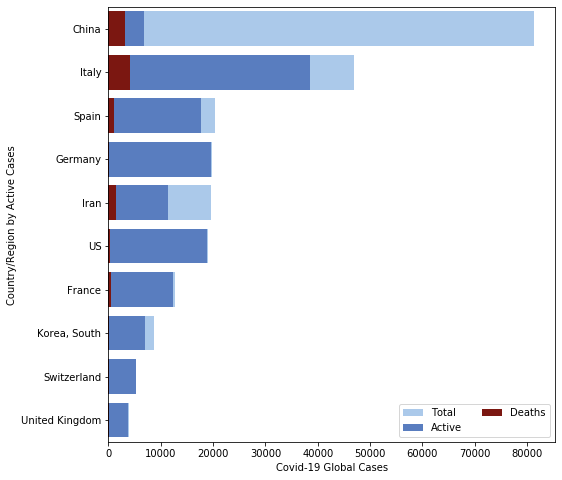

In [13]:
f, ax = plt.subplots(figsize=(8, 8))
sns.set_color_codes("pastel")
sns.barplot(x = covid_19_df['Confirmed'], y = covid_19_df['Country/Region'][:10], data=covid_19_df, label="Total", color="b")
sns.set_color_codes("muted")
sns.barplot(x = covid_19_df['Active'], y = covid_19_df['Country/Region'][:10], data=covid_19_df, label="Active", color="b")
sns.set_color_codes("dark")
sns.barplot(x = covid_19_df['Deaths'], y = covid_19_df['Country/Region'][:10], data=covid_19_df, label="Deaths", color="r")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel = 'Country/Region by Active Cases', xlabel="Covid-19 Global Cases")

Plot is sorted by active cases because it is important referent to the current situation

In [14]:
a = total.melt()[1:]
a

,variable,value
1,Deaths,11299
2,Recovered,87256
3,Active,173611


In [15]:
labels = list(a.variable)
var = list(a.value)

### Proportions of cases according to status

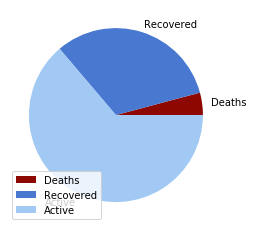

In [16]:
plt.pie(var, labels=labels, colors = ['#8c0800', '#4878d0', '#a1c9f4'])
plt.legend(labels, loc="best")
plt.show()

### Importing median age data and mergig into basic dataset

In [17]:
median_age = pd.read_csv('countries_median_age.csv', header=None)
median_age.columns = ['Country/Region', 'Median Age']

In [18]:
covid_19_df = covid_19_df.reset_index()

In [19]:
covid_19_df = pd.merge(covid_19_df, median_age, on = 'Country/Region')

In [20]:
covid_19_df.head(2)

,index,Country/Region,Confirmed,Deaths,Recovered,Active,Median Age
0,32,China,81250,3253,71266,6731,37.4
1,76,Italy,47021,4032,4440,38549,45.5


### Adding case fatality rate (CFR) to check if there is visible dependency on deaths and median age of country

for countries where confirmed cases > 50

In [21]:
covid_19_df_cft = covid_19_df.copy()

In [22]:
covid_19_df_cft['CFT(%)'] = (covid_19_df_cft['Deaths']/covid_19_df_cft['Confirmed'] * 100).round(2)

In [23]:
covid_19_df_cft = covid_19_df_cft[(covid_19_df_cft['Deaths'] > 0) & 
                                   (covid_19_df_cft['Confirmed'] > 50)]

In [24]:
covid_19_df_cft.sort_values(by=['CFT(%)'], ascending=False).reset_index(drop=True).head(5)

,index,Country/Region,Confirmed,Deaths,Recovered,Active,Median Age,CFT(%)
0,2,Algeria,90,11,32,47,28.1,12.22
1,129,San Marino,144,14,4,126,44.4,9.72
2,71,Indonesia,369,32,15,322,30.2,8.67
3,76,Italy,47021,4032,4440,38549,45.5,8.57
4,73,Iraq,208,17,49,142,20.0,8.17


### Visualization for CFT comparing to Median age for countries with confirmed cases > 50

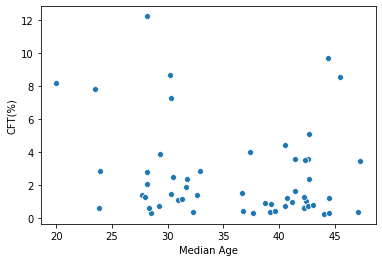

In [25]:
sns.scatterplot(covid_19_df_cft['Median Age'], covid_19_df_cft['CFT(%)'])

### Plot above is not answering any question, so I will check for countries that have confirmed cases > 1000

In [26]:
covid_19_df_cft = covid_19_df_cft[(covid_19_df_cft['Deaths'] > 0) & 
                                  (covid_19_df_cft['Confirmed'] > 1000)]
len(covid_19_df_cft)

16

There is 16 countries with more than 1000 cases

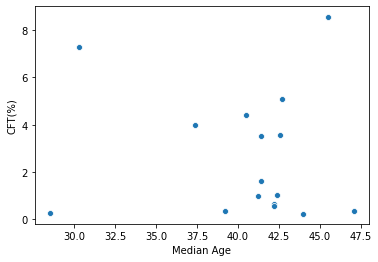

In [27]:
sns.scatterplot(covid_19_df_cft['Median Age'], covid_19_df_cft['CFT(%)'])

Probably after a few weeks, there will be more accurate data to find the relationship but for now on this data it is visible that the countries with Median Age above 40 have more death cases.

### Current relation confirmed cases vs deaths

In [28]:
top_20_deaths = covid_19_df_cft.sort_values('Deaths', ascending=False).iloc[:20, :]
top_20_deaths.head(3)

,index,Country/Region,Confirmed,Deaths,Recovered,Active,Median Age,CFT(%)
1,76,Italy,47021,4032,4440,38549,45.5,8.57
0,32,China,81250,3253,71266,6731,37.4,4.00
4,72,Iran,19644,1433,6745,11466,30.3,7.29


#### visualization on logarythmic scale

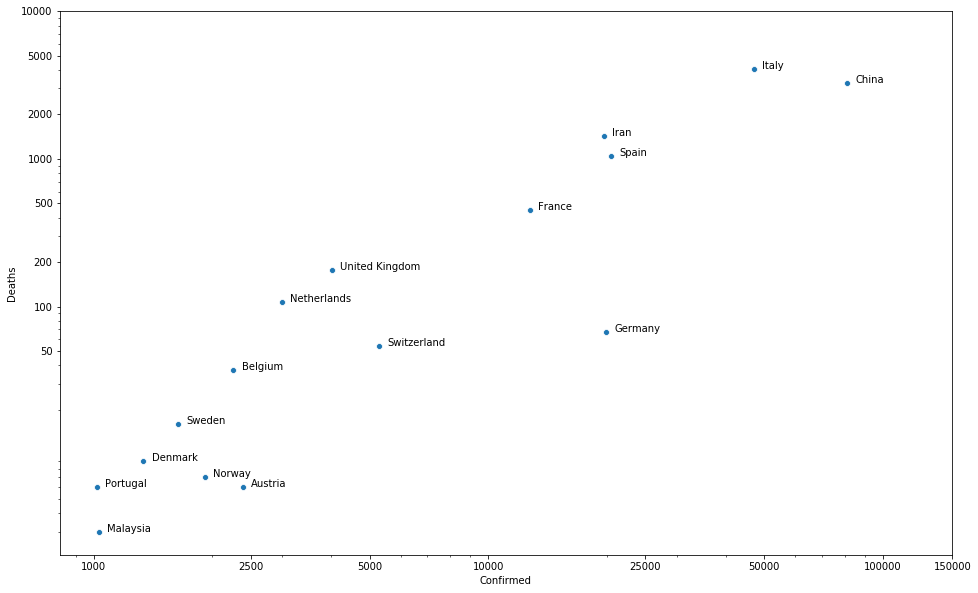

In [29]:
df = top_20_deaths.reset_index(drop=True)
x = 'Confirmed'
y = 'Deaths'
fig, ax = plt.subplots(figsize=(16, 10))
ax = sns.scatterplot(x = x, y = y, data = top_20_deaths)
ax.set(xscale="log")
ax.set(yscale="log")
ax.set_xticks([1000, 2500, 5000, 10_000, 25_000, 50_000, 100_000, 150_000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([50, 100, 200, 500, 1000, 2000, 5000, 10_000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
for i in range(0,df.shape[0]):
    ax.text(df[x][i]+ 0.05 * df[x][i], df[y][i], df['Country/Region'][i], horizontalalignment='left', size='medium', color='black')